In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten ,Reshape, Input ,Conv2D ,Conv2DTranspose, BatchNormalization,LeakyReLU, Dropout
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(x_train,y_train),(x_test,y_test)=keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
x_dataset=tf.data.Dataset.from_tensor_slices(x_train)

def process_x(x):
  img=(tf.cast(x,tf.float32 )-127.5)/127.5
  img=tf.expand_dims(img,axis=2)
  img=tf.image.resize(img,(32,32))
  return img

dataset=x_dataset.map(process_x)
dataset=dataset.shuffle(1000)
dataset=dataset.batch(256)
AUTOTUNE=tf.data.AUTOTUNE
dataset=dataset.cache().prefetch(buffer_size=AUTOTUNE)

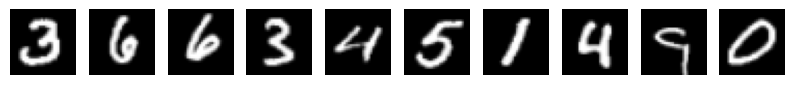

In [4]:
def imshow():
  n=10
  plt.figure(figsize=(10,6))
  for images in dataset.take(1):
    for i in range(n):
      img=images[i]
      ax=plt.subplot(3,n,i+1+n)
      plt.imshow(img,cmap='gist_gray')
      plt.axis('off')
      ax.get_yaxis().set_visible(False)
  plt.show()
imshow()

In [5]:
inputs=Input(shape=(128,))
x = Dense(8*8*256,use_bias=False)(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Reshape((8,8,256))(x)
x = Conv2DTranspose(256,3,strides=(1,1),padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(128,3,strides=(2,2),padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(64,3,strides=(2,2),padding='same',use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(1,3,strides=(1,1),padding='same',use_bias=False,activation="tanh")(x)
outputs=x
generator=keras.Model(inputs,outputs)

In [6]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 16384)             2097152   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         589824    
 anspose)                                                    

In [7]:
inputs=Input(shape=(32,32,1))

x = Conv2D(64,3,strides=(2,2),padding='same',use_bias=False)(inputs)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = Conv2D(128,3,strides=(2,2),padding='same',use_bias=False)(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = Conv2D(128,3,strides=(2,2),padding='same',use_bias=False)(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(1,activation='sigmoid')(x)

outputs=x
disctriminator=keras.Model(inputs,outputs)


In [8]:
class Model(tf.keras.Model):
  def __init__(self,gen,disc):
    super(Model,self).__init__()
    self.gen=gen
    self.disc=disc

    self.gen_optimizer=tf.keras.optimizers.Adam(1e-4)
    self.disc_optimizer=tf.keras.optimizers.Adam(1e-4)


  def gan_loss(self,logits,is_real):
    if is_real:
      labels=tf.ones_like(logits)
    else:
      labels=tf.zeros_like(logits)
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels,logits)
    return loss

  @tf.function
  def training_step(self,x):

    noise=tf.random.normal([1000,128],0,1,tf.float32)
    with tf.GradientTape() as disc_tape ,tf.GradientTape() as gen_tape:
      fake_images=self.gen(noise,training=True)
      real_images=x

      fake_result=self.disc(fake_images,training=True)
      real_result=self.disc(real_images,training=True)

      disc_fake_loss=self.gan_loss(fake_result,False)
      disc_real_loss=self.gan_loss(real_result,True)

      disc_loss=disc_fake_loss + disc_real_loss
      gen_loss=self.gan_loss(fake_result,True)

    disc_gradients = disc_tape.gradient(disc_loss,self.disc.trainable_variables)
    self.disc_optimizer.apply_gradients(zip(disc_gradients,self.disc.trainable_variables))

    gen_gradients = gen_tape.gradient(gen_loss,self.gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(gen_gradients,self.gen.trainable_variables))

    return tf.reduce_mean(disc_loss)

In [9]:
model=Model(generator,disctriminator)

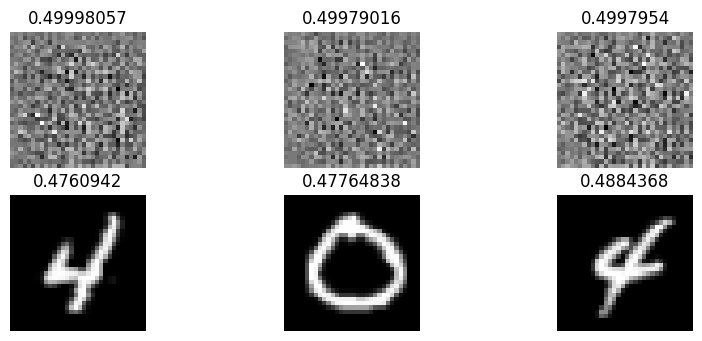

In [10]:
def generate():
  n=3
  plt.figure(figsize=(10,6))
  for ll in dataset.take(1):
    ims=ll
  for i in range(n):
    img=model.gen(tf.random.normal([1,128],0,1,tf.float32))
    img=tf.squeeze(img,axis=0)
    ax=plt.subplot(3,n,i+1)
    plt.imshow(img*127.5+127.5,cmap='gist_gray')
    plt.title(model.disc(tf.expand_dims(img,axis=0)).numpy()[0][0])
    plt.axis("off")
    ax=plt.subplot(3,n,i+1+n)
    plt.imshow(ims[i]*127.5+127.5,cmap='gist_gray')
    plt.title(model.disc(tf.expand_dims(ims[i],axis=0)).numpy()[0][0])
    ax.get_yaxis().set_visible(False)
    plt.axis("off")
  plt.show()
generate()

50


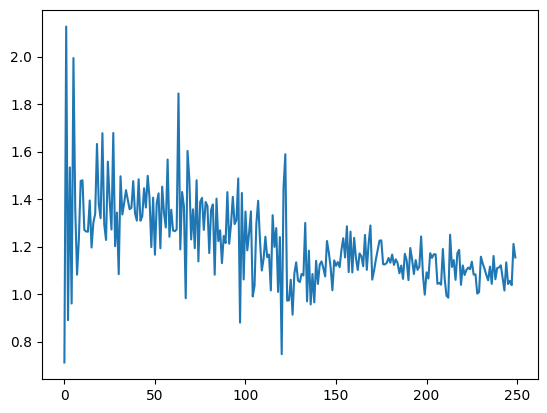

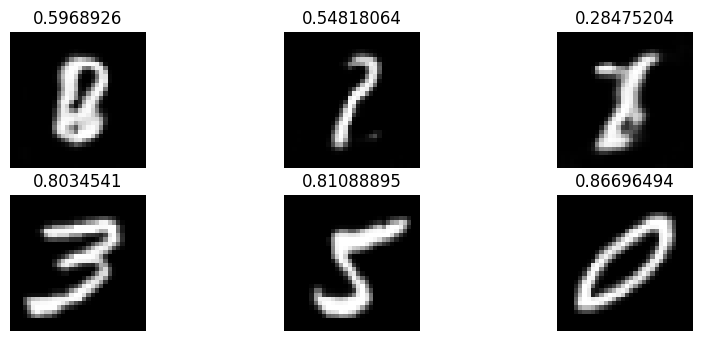

In [12]:
epochs=50
from IPython.display import clear_output
hist=np.array(np.empty([0]))

for epoch in range(1,epochs+1):
  for step, x in enumerate(dataset):
    loss=model.training_step(x)
    if step%50==0:
      clear_output(wait=True)
      print(epoch)
      hist=np.append(hist,loss)
      plt.plot(np.arange(0,len(hist)),hist)
      plt.show()
      generate()

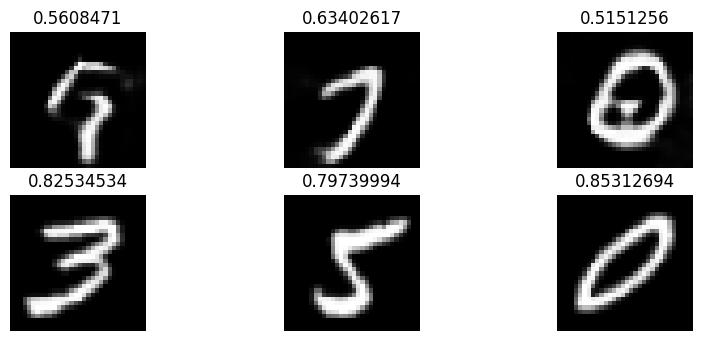

In [13]:
generate()

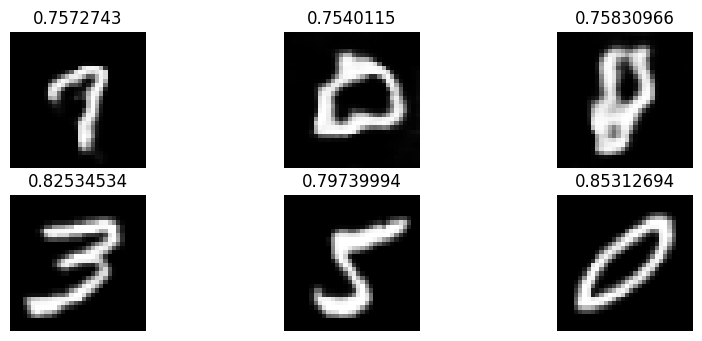

In [14]:
generate()

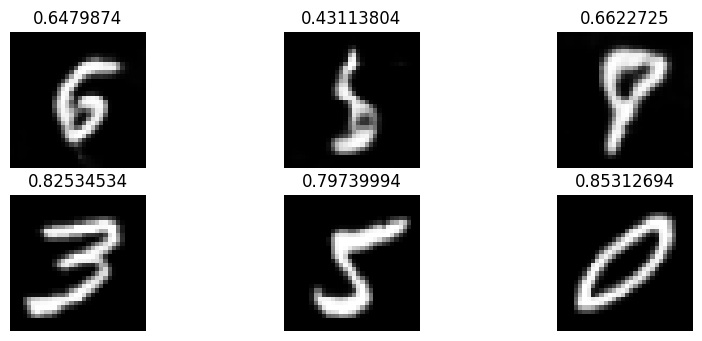

In [27]:
generate()